# Logistic regression for dcGAN generated data

In this notebook show how to compute the learning curves for a logistic regression task on synthetic CIFAR10-like data generated by a trained dcGAN. Concretely, in this notebook we will look at the following setting:

- **Generator:** Our generator will be the dcGAN from [Radford et al.](https://arxiv.org/abs/1511.06434) trained to map i.i.d. Gaussian noise $z\sim\mathcal{N}(0,\rm{I}_{100})\mapsto x\in\mathbb{R}^{D}$ into CIFAR10-looking images. For more details, check notebook `synthetic_data_pipeline.ipynb`.
- **Labels:** The labels $y^{\mu}\in\{-1, +1\}$ are assigned to the dcGAN generated images using teacher features $\varphi_{t}:\mathbb{R}^{D}\to\mathbb{R}^{p}$ and teacher weights $\theta_{0}\in\mathbb{R}^{p}$ trained on real grayscale CIFAR10 images. In this example, the teacher is a fully-connected neural network trained of a odd (+1) vs even (-1) classification task on real CIFAR10 images. The first layers of the teacher define the teacher feature map $\varphi_{t}: x\in\mathbb{R}^{D}\mapsto u\in\mathbb{R}^{p}$ and the last layer the teacher weights $\theta_{0}\in\mathbb{R}^{p}$.
- **Student features:** The student feature map $\varphi_{s}:x\in\mathbb{R}^{D}\mapsto u\in\mathbb{R}^{d}$ will be a fully-connected neural network trained on 30k fake CIFAR10-like images sampled from the generator above, with lablels assigned by the teacher also described above. 
- **Minimisation problem:** Given the synthetic data $\{x^{\mu}, y^{\mu}\}_{\mu=1}^{n}$ generated as described above, our goal is to study the performance of the estimator $\hat{y} = \rm{sign}\left(V\hat{w}\right)$ where $V\in\mathbb{R}^{n\times d}$ is the feature matrix, with entries $v^{\mu} = \varphi_{s}(x) / \sqrt{d}$ and $\hat{w}\in\mathbb{R}^{d}$ is obtained by minimising the empirical risk:
\begin{align}
\hat{w} = \rm{argmin}\left[\sum\limits_{\mu=1}^{n}\log\left(1+e^{-y^{\mu} \frac{v^{\mu}\cdot w}{\sqrt{d}}}\right)+\frac{\lambda}{2}||w||^2_{2}\right]
\end{align}

## Global variables

In [1]:
# L2 regularisation strength
lamb = 0.01

## Theoretical curves

Note that for computing the theoretical learning curves, we need to provide the covariances $(\Psi, \Phi, \Omega)$ and the teacher vector $\theta_{0}$. The last is defined directly by the teacher, while the first three ara estimated using a Monte-Carlo algorithm that we discuss in the notebook `monte_carlo.ipynb`. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import teachers
import teacherutils

import sys
sys.path.append("..")
from state_evolution.data_models.custom import Custom # Custom data model. You input the covariances
from state_evolution.experiments.learning_curve import CustomExperiment

Load the covariances $(\Psi, \Phi, \Omega)$:

In [3]:
Omega = np.load('./data/covariances/omega_t=mlp_s=mlp_epoch=200_n=1e6.npy')
Psi = np.load('./data/covariances/psi_t=mlp_s=mlp_epoch=200_n=1e6.npy')
Phi = np.load('./data/covariances/phi_t=mlp_s=mlp_epoch=200_n=1e6.npy')

# Dimensions
p, d = Phi.shape
gamma = p/d

Load the teacher weights $\theta_{0}$. See `synthetic_data_pipeline.ipynb` for more info.

In [4]:
dx, dy, c = 32, 32, 3 # teacher input dimension
D = dx*dy*c

# Load teacher vector
kwargs = {"input_dim": [1, dx, dy]}
teacher_mlp = teacherutils.get_model("mlp", "erf", D, 1, **kwargs)
teacher_mlp.load_state_dict(torch.load("./data/weights/mlp_erf_cifar10.pt", 
                                       map_location=device))

teacher_weights = teacher_mlp.fc.weight.data.numpy()
teacher_weights = teacher_weights.reshape(p,)

In [5]:
print('Loading data model')
data_model = Custom(teacher_teacher_cov = Psi, 
                    student_student_cov = Omega, 
                    teacher_student_cov = Phi,
                    teacher_weights = teacher_weights)

print('Loading experiment')
experiment = CustomExperiment(task = 'logistic_regression', 
                              regularisation = lamb, 
                              data_model = data_model, 
                              tolerance = 1e-7, 
                              damping = 0.5, 
                              verbose = False, 
                              max_steps = 1000)

Loading data model
Loading experiment


In [23]:
sc_range = np.linspace(0.01, 0.5, 100) # sample complexity range
experiment.learning_curve(alphas = sc_range)

# Getting learning curve as pd.DataFrame
theory = experiment.get_curve()

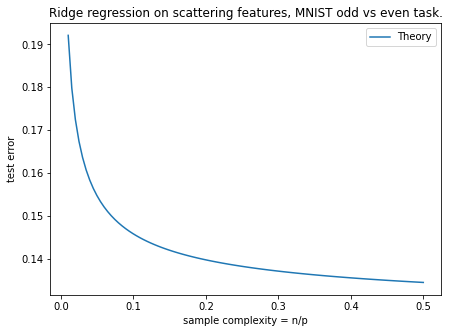

In [24]:
fig, ax = plt.subplots(figsize=(7,5))

plt.title('Ridge regression on scattering features, MNIST odd vs even task.')

theory.plot(x='sample_complexity', y='test_error', style='-', 
              ax=ax, label='Theory')

plt.ylabel(r"test error")
plt.xlabel(r"sample complexity = n/p")

plt.legend()

## Simulations

Different from the real data setting, here we have access to the distribution of the data. Therefore, we can sample as many fresh samples as needed. 

First, we load our generator as usual:

In [8]:
from dcgan import Generator
from simulate_gan import simulate

%load_ext autoreload
%autoreload 2

In [9]:
# Load the generator
latent_dim = 100 # generator latent dimension

generator = Generator(ngpu=1)
generator.load_state_dict(torch.load("./data/weights/dcgan_cifar10_weights.pth", map_location=device))

<All keys matched successfully>

Note that the teacher weights was already defined above. We are just missing the teacher feature map $\varphi_{t}$ in order to produce the labels:

In [14]:
teacher_map = lambda x: teacher_mlp.preprocess(x).detach().numpy()

Now, we need to load the student feature map:

In [15]:
# Load student
d = D
student = torch.nn.Sequential(
    torch.nn.Linear(D, p, bias=False),
    torch.nn.ReLU(),
    torch.nn.Linear(p,p, bias=False),
    torch.nn.ReLU(),
    torch.nn.Linear(p,1, bias=False))

# Load weights.
student.load_state_dict(torch.load('./data/weights/weights_mlp_student_epochs=200.pth', map_location=device))

# Extract feature map
student_map = lambda x: student[:-1](x).detach().numpy()

Finally, since for the theory we assume $(u,v)$ have zero-mean, we need to remove the mean induced by the feature maps:

In [18]:
mean_u = np.load('./data/covariances/mean_u_t=mlp_s=mlp_epoch=200_n=1e6.npy')
mean_v = np.load('./data/covariances/mean_v_t=mlp_s=mlp_epoch=200_n=1e6.npy')

In [22]:
sc_range = np.linspace(0.1, 0.5, 10)
sim = simulate(sc_range = sc_range, 
               lamb = lamb, 
               seeds = 10,
               loss = 'logistic', 
               task = 'classification', 
               generator = generator,
               teacher_map = teacher_map, 
               student_map = student_map, 
               teacher_weights = teacher_weights, 
               mean_v = mean_v, 
               mean_u = mean_u)

Simulating sample complexity: 0.1
Seed: 0
Seed: 1
Seed: 2
Seed: 3
Seed: 4
Seed: 5
Seed: 6
Seed: 7
Seed: 8
Seed: 9
Simulating sample complexity: 0.14444444444444446
Seed: 0
Seed: 1
Seed: 2
Seed: 3
Seed: 4
Seed: 5
Seed: 6
Seed: 7
Seed: 8
Seed: 9
Simulating sample complexity: 0.18888888888888888
Seed: 0
Seed: 1
Seed: 2
Seed: 3
Seed: 4
Seed: 5
Seed: 6
Seed: 7
Seed: 8
Seed: 9
Simulating sample complexity: 0.23333333333333334
Seed: 0
Seed: 1
Seed: 2
Seed: 3
Seed: 4
Seed: 5
Seed: 6
Seed: 7
Seed: 8
Seed: 9
Simulating sample complexity: 0.2777777777777778
Seed: 0
Seed: 1
Seed: 2
Seed: 3
Seed: 4
Seed: 5
Seed: 6
Seed: 7
Seed: 8
Seed: 9
Simulating sample complexity: 0.32222222222222224
Seed: 0
Seed: 1
Seed: 2
Seed: 3
Seed: 4
Seed: 5
Seed: 6
Seed: 7
Seed: 8
Seed: 9
Simulating sample complexity: 0.3666666666666667
Seed: 0
Seed: 1
Seed: 2
Seed: 3
Seed: 4
Seed: 5
Seed: 6
Seed: 7
Seed: 8
Seed: 9
Simulating sample complexity: 0.4111111111111111
Seed: 0
Seed: 1
Seed: 2
Seed: 3
Seed: 4
Seed: 5
Seed: 6
See

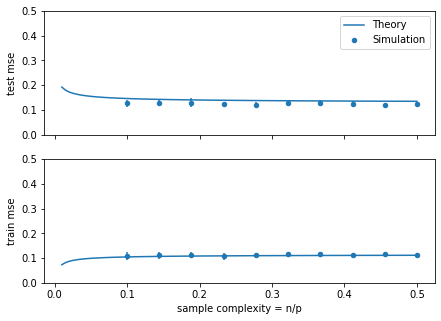

In [29]:
fig, ax = plt.subplots(2,1, figsize=(7,5), sharex=True)

# Test error
theory.plot(x='sample_complexity', 
            y='test_error', 
            style='-', 
            ax=ax[0], 
            label='Theory')

sim.plot(x='sample_complexity', 
         y='test_error', 
         style='.', 
         kind='scatter',
         yerr = 'test_error_std', 
         ax=ax[0], 
         label='Simulation')

theory.plot(x='sample_complexity', 
            y='train_loss', 
            style='-', 
            ax=ax[1], 
            legend=False)

sim.plot(x='sample_complexity', 
         y='train_loss', 
         style='.', 
         kind='scatter',
         yerr = 'train_loss_std', 
         ax=ax[1], 
         legend=False)


ax[0].set_ylabel(r"test mse")
ax[1].set_ylabel(r"train mse")
ax[0].set_ylim([0, 0.5])
ax[1].set_ylim([0, 0.5])

plt.xlabel(r"sample complexity = n/p")

ax[0].legend()